# Momentum distributions

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ May 30, 2023

Plots single-nucleon momentum distributions which are calculated using SRG-evolved momentum projection operators with low-resolution nuclear wavefunctions approximated as a single Slater determinant of Woods-Saxon single-particle orbitals.

_Last update:_ January 29, 2024

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
# Imports from scripts
from scripts.figures import (
    label_kvnn, label_lambda, label_nucleus, set_rc_parameters
)
from scripts.integration import momentum_mesh
from scripts.momentum_distributions import MomentumDistribution
from scripts.tools import convert_number_to_string, replace_periods

# from test_momentum_distribution_script_v9 import load_momentum_distribution
from test_momentum_distribution_script_v9 import compute_normalization

### Set-up

In [3]:
def label_potential_lambda(kvnn, lamb):
    """Label for potential and SRG \lambda."""
    
    kvnn_label = label_kvnn(kvnn)
    lamb_label = rf"$({convert_number_to_string(lamb)})$"
    
    return kvnn_label + lamb_label

In [4]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

In [5]:
# Save figures in the following directory
figures_directory = '../figures/momentum_distributions/'
vmc_directory = '../data/vmc/momentum_distributions/'

In [6]:
def load_momentum_distribution(
    nucleus_name, nucleon, kvnn, lamb, kvnn_hard=None, lambda_m=None,
    parametrization='Match'
):
    """Load and return the momentum distribution along with the isolated
    contributions.
    """
    
    directory = f"../data/momentum_distributions/{nucleus_name}/"

    if kvnn_hard is not None:
        file_name = replace_periods(
            f"{nucleus_name}_{nucleon}_momentum_distribution_kvnn_{kvnn}_lamb"
            f"_{lamb}_kvnn_hard_{kvnn_hard}_lambda_m_{lambda_m}"
        )
    else:
        file_name = replace_periods(
            f"{nucleus_name}_{nucleon}_momentum_distribution_kvnn_{kvnn}_lamb"
            f"_{lamb}"
        )
    
    ### TESTING
    if parametrization != '':
        file_name += f'_{parametrization}'
    
    data = np.loadtxt(directory + file_name + '.txt')
    
    q_array = data[:, 0]
    q_weights = data[:, 1]
    n_array = data[:, 2]
    n_errors = data[:, 3]
    I_array = data[:, 4]
    delta_U_array = data[:, 5]
    delta_U_errors = data[:, 6]
    delta_U2_array = data[:, 7]
    delta_U2_errors = data[:, 8]
    
    return (q_array, q_weights, n_array, n_errors, I_array, delta_U_array,
            delta_U_errors, delta_U2_array, delta_U2_errors)

## Comparison of Woods-Saxon parametrizations

In [7]:
def compare_woods_saxon(
        nucleus_name, Z, kvnn, lamb, x_limits=(0.0,6.0), y_limits=(1e-4,1e3),
        y_scale='log', show_vmc=False, save=False
):
    """Compare the Seminole and Universal Woods-Saxon parametrizations."""
    
    # AV18 and AV18 + UIX
    if nucleus_name == 'O16' or nucleus_name == 'Ca40':
        
        filename_2b = f"{nucleus_name}_single_nucleon_av18.txt"
        label_2b = "AV18"
        filename_3b = f"{nucleus_name}_single_nucleon_av18_uix.txt"
        label_3b = "AV18 + UIX"
        
    # AV18 and AV18 + UX
    elif nucleus_name == 'He4':
        
        filename_2b = f"{nucleus_name}_single_nucleon_av18.txt"
        label_2b = "AV18"
        filename_3b = f"{nucleus_name}_single_nucleon_av18_ux.txt"
        label_3b = "AV18 + UX"
    
    # AV18 + UIX and AV18 + UX
    elif nucleus_name == 'C12':
        
        filename_2b = f"{nucleus_name}_single_nucleon_av18_uix.txt"
        label_2b = "AV18 + UIX"
        filename_3b = f"{nucleus_name}_single_nucleon_av18_ux.txt"
        label_3b = "AV18 + UX"
        
    data_2b = np.loadtxt(vmc_directory + filename_2b)
    q_2b = data_2b[:,0]
    n_2b = data_2b[:,1] / Z
    n_errors_2b = data_2b[:,2] / Z
    
    data_3b = np.loadtxt(vmc_directory + filename_3b)
    q_3b = data_3b[:,0]
    n_3b = data_3b[:,1] / Z
    n_errors_3b = data_3b[:,2] / Z
    
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    if y_scale == 'linear':
        ax.set_yscale('linear')
    elif y_scale == 'log':
        ax.set_yscale('log')
        
    if y_scale == 'linear':
        
        if show_vmc:
            ax.errorbar(q_2b, n_2b * q_2b ** 2, yerr=n_errors_2b * q_2b ** 2, 
                        label=label_2b, ls='', marker='.')
            ax.errorbar(q_3b, n_3b * q_3b ** 2, yerr=n_errors_3b * q_3b ** 2,
                        label=label_3b, ls='', marker='.')
        
    elif y_scale == 'log':
        
        if show_vmc:
            ax.errorbar(q_2b, n_2b, yerr=n_errors_2b, label=label_2b, ls='',
                        marker='.')
            ax.errorbar(q_3b, n_3b, yerr=n_errors_3b, label=label_3b, ls='',
                        marker='.')
        
    # Load data from file
    q_s, qw_s, nq_s, _, _, _, _, _, _ = load_momentum_distribution(
        nucleus_name, 'proton', kvnn, lamb, parametrization='Seminole')
    q_u, qw_u, nq_u, _, _, _, _, _, _ = load_momentum_distribution(
        nucleus_name, 'proton', kvnn, lamb, parametrization='Universal')
    
    # Multiply by factor (2\pi)^3 / Z to compare to VMC data
    nq_s *= (2*np.pi) ** 3 / Z
    nq_u *= (2*np.pi) ** 3 / Z

    # Add to plot
    if y_scale == 'linear':
        
        ax.plot(q_s, nq_s * q_s ** 2, label='Seminole', lw=2.0)
        ax.plot(q_u, nq_u * q_u ** 2, label='Universal', ls='dashdot', lw=2.0)

    else:
        
        ax.plot(q_s, nq_s, label='Seminole', lw=2.0)
        ax.plot(q_u, nq_u, label='Universal', ls='dashdot', lw=2.0)
        
    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    if y_scale == 'linear':
        ylabel = r"$q^2 n_p(q) / Z$ [fm]"
    elif y_scale == 'log':
        ylabel = r"$n_p(q) / Z$ [fm" + r'$^3$' + ']'
    ax.set_ylabel(ylabel, fontsize=16)

    # Add nucleus label
    if y_scale == 'log':
        nucleus_label_loc = 'lower left'
    elif y_scale == 'linear':
        nucleus_label_loc = 'upper left'
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc=nucleus_label_loc,
                     prop=dict(size=18), frameon=False)
    )
        
    # Set legend in first panel only
    ax.legend(loc='upper right', fontsize=12, frameon=False)
    
    # Save?
    if save:   
        file_name = replace_periods(
            f"{nucleus_name}_ws_comparison_kvnn_{kvnn}_lamb_{lamb}_{y_scale}"
            "_scale"
        )
        f.savefig(figures_directory + file_name + '.png')

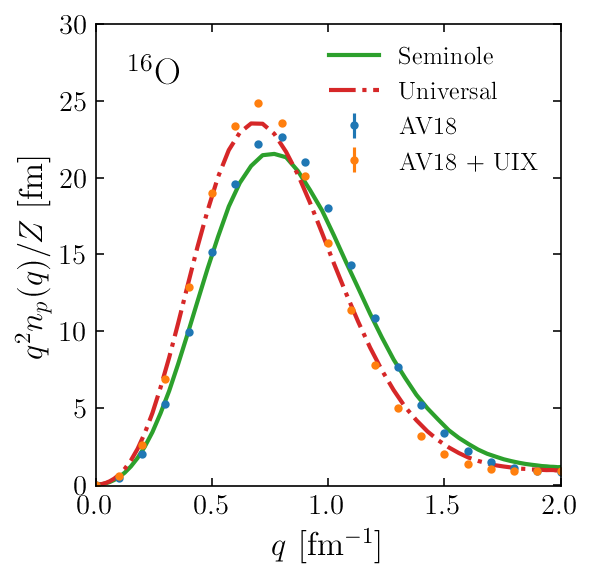

In [8]:
compare_woods_saxon('O16', 8, 6, 1.5, x_limits=(0,2), y_limits=(-0.1, 30),
                    y_scale='linear', show_vmc=True, save=True)

## Comparison to VMC

In [9]:
def single_nucleon_momentum_distributions_multipanel(
        nuclei, nucleon, kvnn, lamb, x_limits=(0.0,6.0), y_limits=(1e-4,1e3),
        y_scale='log', show_vmc=False, save=False
):
    """Plot a single-nucleon momentum distribution with several built-in
    options.
    """
    
    # Initialize figure
    plt.close('all')
    row_number, col_number = 1, len(nuclei)
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True,
                          figsize=(4*col_number, 4*row_number))
        
    # Loop over nuclei
    for i, nucleus in enumerate(nuclei):
        
        nucleus_name, Z, N = nucleus
        if nucleon == 'proton':
            factor = Z
        elif nucleon == 'neutron':
            factor = N
            
        if y_scale == 'log':
            axs[i].set_yscale('log')
        else:
            axs[i].set_yscale('linear')
        
        # Compare to VMC calculation?
        if show_vmc:

            # AV18 + UX
            if nucleus_name == 'He4' or nucleus_name == 'C12':
                file_name = f"{nucleus_name}_single_nucleon_av18_ux.txt"
            # AV18 + UIX
            elif nucleus_name == 'O16' or nucleus_name == 'Ca40':
                file_name = f"{nucleus_name}_single_nucleon_av18_uix.txt"
                
            data = np.loadtxt(vmc_directory + file_name)
            q_vmc = data[:,0]
            n_vmc = data[:,1] / factor
            n_errors = data[:,2] / factor
        
            if y_scale == 'linear':
            
                axs[i].errorbar(
                    q_vmc, n_vmc * q_vmc ** 2, yerr=n_errors * q_vmc ** 2,
                    color='black', label='VMC', linestyle='', marker='.',
                    zorder=3
                )
            
            else:
            
                axs[i].errorbar(
                    q_vmc, n_vmc, yerr=n_errors, color='black', label='VMC',
                    linestyle='', marker='.', zorder=3
                )

        # Load data from file
        q_array, q_weights, n_array, n_errors, n_ipm_array, _, _, _, _ = (
            load_momentum_distribution(nucleus_name, nucleon, kvnn, lamb)
        )
    
        # Multiply by factor (2\pi)^3 / Z (N) to compare to VMC data
        n_array *= (2*np.pi) ** 3 / factor
        n_errors *= (2*np.pi) ** 3 / factor
        n_ipm_array *= (2*np.pi) ** 3 / factor

        # Add to plot
        if y_scale == 'linear':
        
            # SRG
            axs[i].plot(q_array, n_array * q_array ** 2, label='SRG',
                        linewidth=2.0, zorder=2)
            # IPM
            axs[i].plot(q_array, n_ipm_array * q_array ** 2, label='IPM',
                        linestyle='dotted', linewidth=2.0, zorder=1)

        else:
        
            # SRG
            axs[i].plot(q_array, n_array, label='SRG', linewidth=2.0, zorder=2)
            # IPM
            axs[i].plot(q_array, n_ipm_array, label='IPM', linestyle='dotted',
                        linewidth=2.0, zorder=1)

        # Set axes limits
        axs[i].set_xlim(x_limits)
        axs[i].set_ylim(y_limits)

        # Set axes labels
        axs[i].set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
        if i == 0:  # First column only
            if y_scale == 'linear' and nucleon == 'proton':
                ylabel = r"$q^2 n_{p}(q)/Z$ [fm]"
            elif y_scale == 'linear' and nucleon == 'neutron':
                ylabel = r"$q^2 n_{n}(q)/N$ [fm]"
            elif y_scale == 'log' and nucleon == 'proton':
                ylabel = r"$n_{p}(q)/Z$ [fm" + r'$^3$' + ']'
            elif y_scale == 'log' and nucleon == 'neutron':
                ylabel = r"$n_{n}(q)/N$ [fm" + r'$^3$' + ']'
            axs[i].set_ylabel(ylabel, fontsize=16)

        # Add nucleus label
        if y_scale == 'log':
            nucleus_label_loc = 'lower left'
        elif y_scale == 'linear':
            nucleus_label_loc = 'upper left'
        axs[i].add_artist(
            AnchoredText(label_nucleus(nucleus_name), loc=nucleus_label_loc,
                         prop=dict(size=18), frameon=False)
        )
        
    # Set legend in first panel only
    axs[0].legend(loc='upper right', fontsize=13, frameon=False)
    
    # Add potential and \lambda label in last panel
    axs[-1].add_artist(
        AnchoredText(label_potential_lambda(kvnn, lamb), loc='upper right',
                     prop=dict(size=18), frameon=False)
    )

    # Amount of white space in-between sub-plots
    f.subplots_adjust(wspace=0.1)

    # Save?
    if save:   
        file_name = replace_periods(
            f"{nucleon}_momentum_distributions_kvnn_{kvnn}_lamb_{lamb}"
            f"_{y_scale}_scale"
        )
        f.savefig(figures_directory + file_name + '.png')

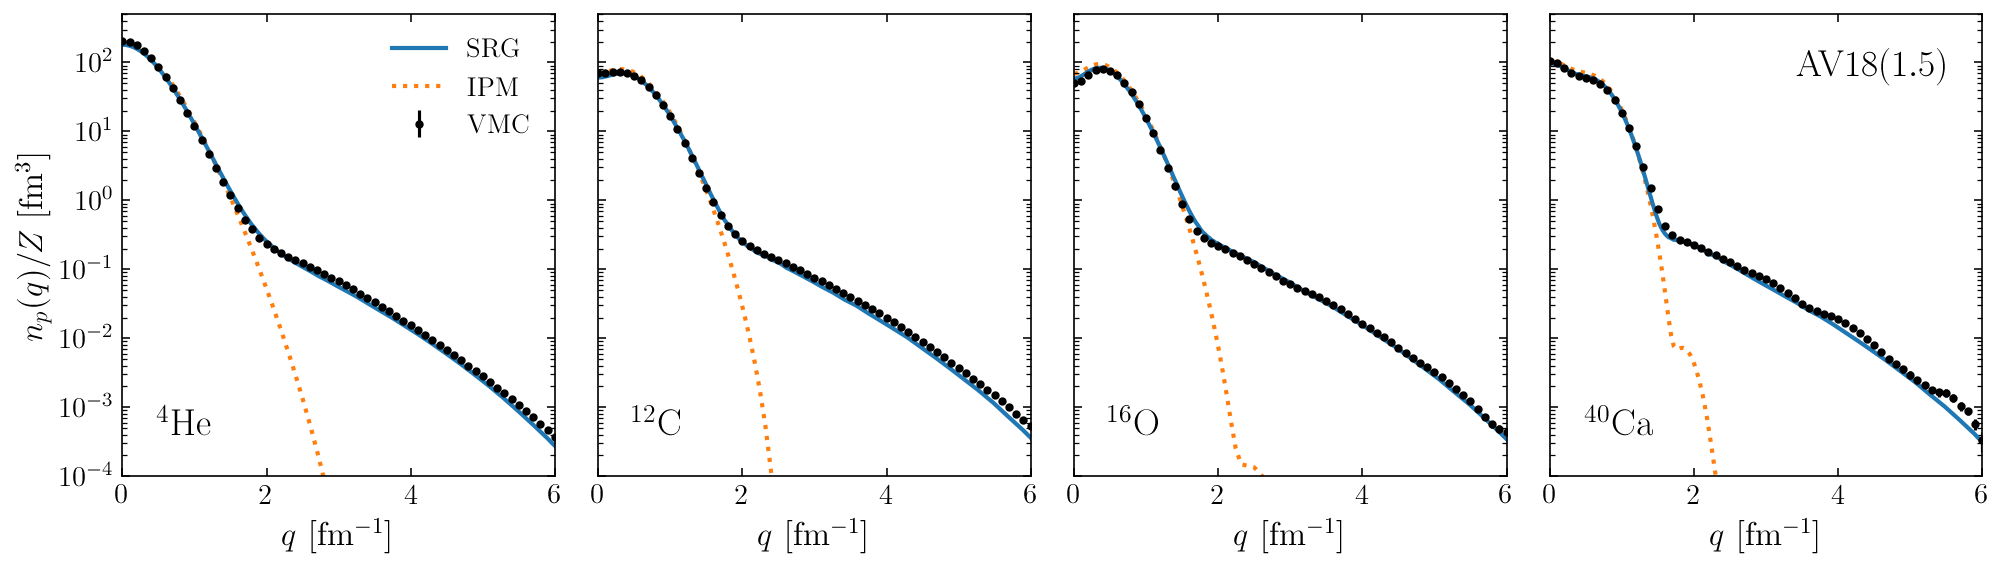

In [10]:
# \lambda = 1.5 fm^-1 log y scale

nuclei = (('He4', 2, 2), ('C12', 6, 6), ('O16', 8, 8), ('Ca40', 20, 20))

single_nucleon_momentum_distributions_multipanel(
    nuclei, 'proton', 6, 1.5, y_limits=(1e-4, 5e2), show_vmc=True, save=True
)

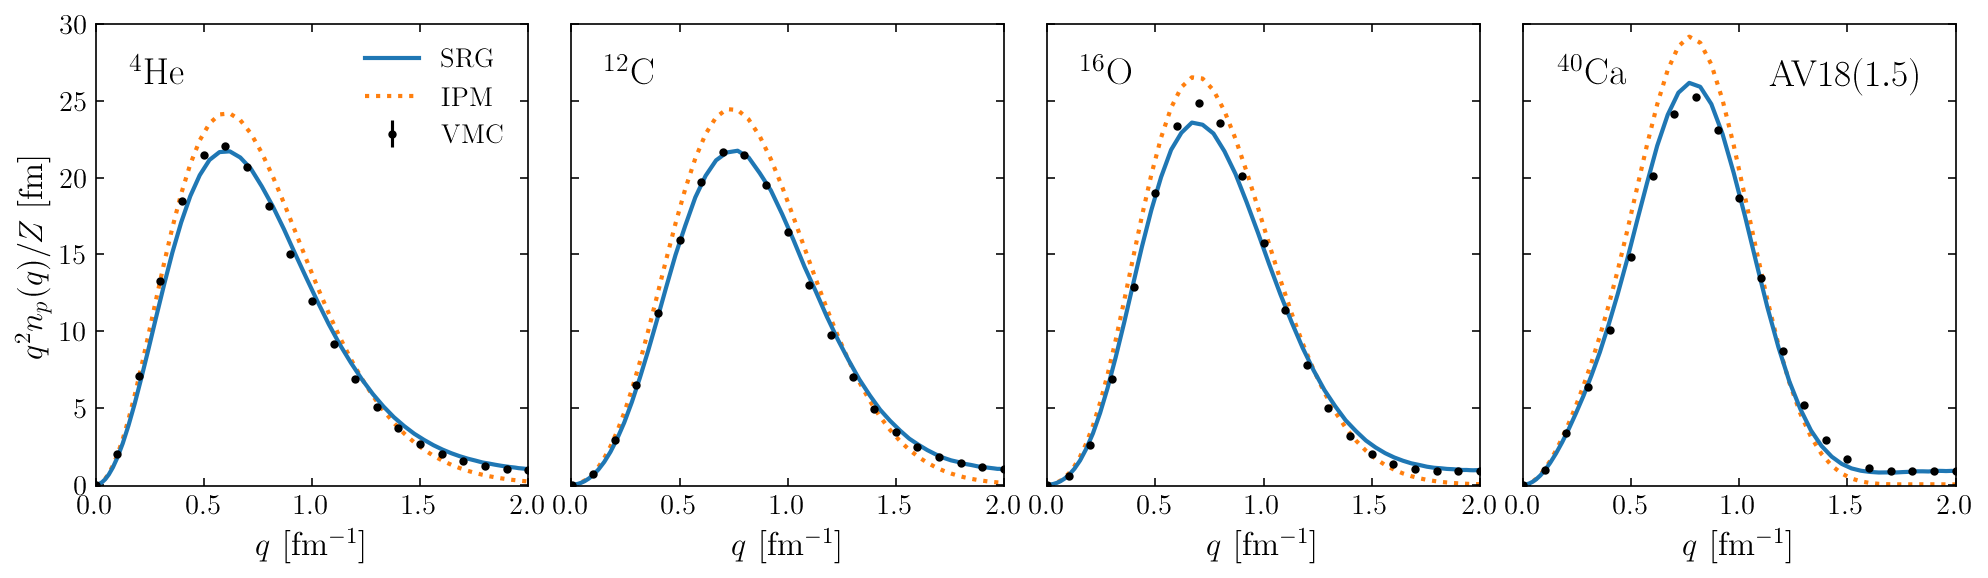

In [11]:
# \lambda = 1.5 fm^-1 linear y scale

nuclei = (('He4', 2, 2), ('C12', 6, 6), ('O16', 8, 8), ('Ca40', 20, 20))

single_nucleon_momentum_distributions_multipanel(
    nuclei, 'proton', 6, 1.5, x_limits=(0.0, 2.0), y_limits=(-0.1, 30),
    y_scale='linear', show_vmc=True, save=True
)

## Contributions of single-nucleon momentum distribution

In [12]:
def single_nucleon_momentum_distribution_contributions(
        nucleus_name, nucleon, kvnn, lamb, number_of_curves=4,
        x_limits=(0.0,6.0), y_limits=(9e-6,1e3), lda=False,
        print_normalization=False, save=False
):
    """Plots momentum distributions showing I, \delta U + \delta U^\dagger, and
    \delta U \delta U^\dagger contributions.
    """
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))

    # Load data from file
    if lda:  # LDA version
        
        md = MomentumDistribution(kvnn, 15.0, 3.0, 120)
        n_total_func, n_I_func, n_delU_func, n_delU2_func = (
            md.get_single_nucleon_momentum_distribution(
                nucleon, nucleus_name, 'SLy4', ('1S0', '3S1'), 'Wegner', lamb,
                contributions=True, interpolate=True
            )
        )
        
        q_array, q_weights = momentum_mesh(15.0, 3.0, 120)
        n_array = n_total_func(q_array)
        n_I_array = n_I_func(q_array)
        n_delU_array = n_delU_func(q_array)
        n_delU2_array = n_delU2_func(q_array)
        
    else:  # Woods-Saxon version
        
        (q_array, q_weights, n_array, _, n_I_array, n_delU_array, _,
         n_delU2_array, _) = load_momentum_distribution(nucleus_name, nucleon,
                                                        kvnn, lamb)
    
    # Print normalization?
    if print_normalization:

        total_norm = compute_normalization(q_array, q_weights, n_array)
        print(f"Total normalization = {total_norm}.")
        
        I_norm = compute_normalization(q_array, q_weights, n_I_array)
        print(f"I normalization = {I_norm}.")
        
        delU_norm = compute_normalization(q_array, q_weights, n_delU_array)
        print(f"\delta U + \delta U^\dagger normalization = {delU_norm}.")
        
        delU2_norm = compute_normalization(q_array, q_weights, n_delU2_array)
        print(f"\delta U \delta U^\dagger normalization = {delU2_norm}.")
        
        relative_error = np.abs(delU_norm + delU2_norm) / delU2_norm * 100
        print(f"Relative error = {relative_error}%.")
        
    # Multiply by factor (2\pi)^3
    if lda:
        factor = 1
    else:
        factor = (2*np.pi) ** 3
    n_array *= factor
    n_I_array *= factor
    n_delU_array *= factor
    n_delU2_array *= factor

    # Add to plot
    ax.semilogy(q_array, n_array, color='black', label='Total', linewidth=2.0,
                zorder=1)
    if number_of_curves > 1:
        ax.semilogy(q_array, n_I_array, color='blue', label='I',
                    linestyle='dotted', linewidth=2.0, zorder=2)
    if number_of_curves > 2:
        ax.semilogy(
            q_array, np.abs(n_delU_array), color='green',
            label=r'$|\delta U+\delta U^\dagger|$', linestyle='dashed',
            linewidth=2.0, zorder=3
        )
    if number_of_curves > 3:
        ax.semilogy(
            q_array, n_delU2_array, color='red',
            label=r'$\delta U \delta U^\dagger$', linestyle='dashdot',
            linewidth=2.0, zorder=4
        )
    
    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    if nucleon == 'proton':
        ylabel = r"$n_{p}(q)$ [fm" + r'$^3$' + ']'
    elif nucleon == 'neutron':
        ylabel = r"$n_{n}(q)$ [fm" + r'$^3$' + ']'
    ax.set_ylabel(ylabel, fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='lower left',
                     prop=dict(size=18), frameon=False)
    )
    
    # Add potential and \lambda label
    ax.add_artist(
        AnchoredText(label_potential_lambda(kvnn, lamb), loc='center right',
                     prop=dict(size=18), frameon=False)
    )

    # Save?
    if save:
        if number_of_curves >= 4:
            file_name = replace_periods(
                f"{nucleus_name}_{nucleon}_momentum_distribution_contributions"
                f"_kvnn_{kvnn}_lamb_{lamb}"
            )
        else:
            file_name = replace_periods(
                f"{nucleus_name}_{nucleon}_momentum_distribution_contributions"
                f"_kvnn_{kvnn}_lamb_{lamb}_{number_of_curves}"
            )
        if lda:
            file_name += "_lda"
        f.savefig(figures_directory + file_name + ".png")

Total normalization = 8.000782762742363.
I normalization = 7.999999999598436.
\delta U + \delta U^\dagger normalization = -0.7933165794542819.
\delta U \delta U^\dagger normalization = 0.7940993425982086.
Relative error = 0.09857244578059343%.


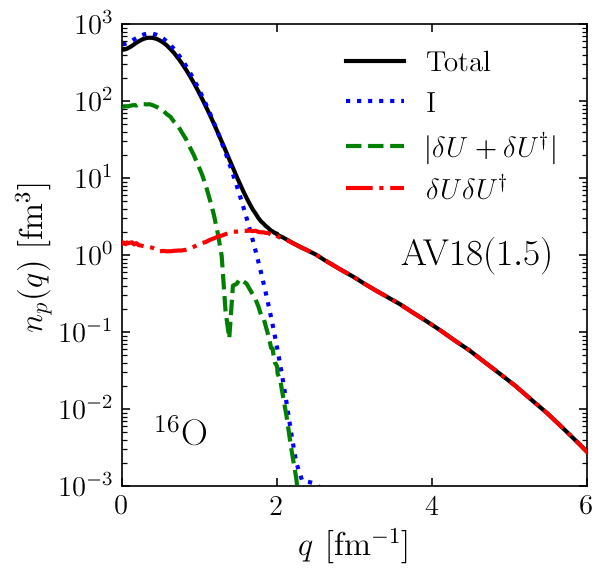

In [13]:
# 16O contributions at \lambda = 1.5 fm^-1
single_nucleon_momentum_distribution_contributions(
    'O16', 'proton', 6, 1.5, y_limits=(1e-3, 1e3), print_normalization=True,
    save=True
)

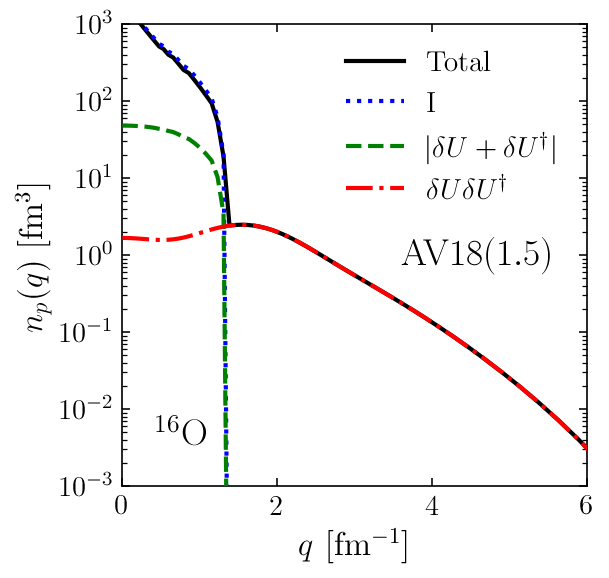

In [14]:
# LDA version of the previous plot
single_nucleon_momentum_distribution_contributions(
    'O16', 'proton', 6, 1.5, y_limits=(1e-3, 1e3), lda=True, save=True
)

## Vary potential

In [15]:
def single_nucleon_momentum_distributions_vary_kvnn(
        nucleus_name, nucleon, kvnns, lamb, x_limits=(0.0,6.0),
        y_limits=(9e-6,1e3), y_scale='log', legend_fontsize=11, save=False
):
    """Plots momentum distributions varying the NN potential."""
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
    
    # Loop over potentials
    for i, kvnn in enumerate(kvnns):
        
        # Load data from file
        (q_array, q_weights, n_array, _, _, _, _, _, _) = (
            load_momentum_distribution(nucleus_name, nucleon, kvnn, lamb)
        )
    
        # Multiply by factor (2\pi)^3
        n_array *= (2*np.pi) ** 3
        
        # Line style
        if i == 0:
            line_style = 'solid'
        elif i == 1:
            line_style = (0, (5, 1))
        elif i == 2:
            line_style = 'dashed'
        elif i == 3:
            line_style = 'dashdot'

        # Add to plot
        if y_scale == 'linear':  # Linear scale
            ax.plot(q_array, n_array * q_array ** 2, label=label_kvnn(kvnn),
                    ls=line_style, lw=2.0, zorder=i)
        elif y_scale == 'log':  # Log scale
            ax.plot(q_array, n_array, label=label_kvnn(kvnn), ls=line_style,
                    lw=2.0, zorder=i)

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    if y_scale == 'linear' and nucleon == 'proton':
        ylabel = r"$q^2 n_{p}(q)$ [fm]"
    elif y_scale == 'linear' and nucleon == 'neutron':
        ylabel = r"$q^2 n_{n}(q)$ [fm]"
    elif y_scale == 'log' and nucleon == 'proton':
        ylabel = r"$n_{p}(q)$ [fm" + r'$^3$' + ']'
    elif y_scale == 'log' and nucleon == 'neutron':
        ylabel = r"$n_{n}(q)$ [fm" + r'$^3$' + ']'
    ax.set_ylabel(ylabel, fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=legend_fontsize, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Add \lambda label
    ax.add_artist(
        AnchoredText(label_lambda(lamb), loc='lower left', prop=dict(size=18),
                     frameon=False)
    )
    
    # Save?
    if save:
        file_name = f"{nucleus_name}_{nucleon}_momentum_distributions_kvnns"
        for kvnn in kvnns:
            file_name += f"_{kvnn}"
        file_name += f"_lamb_{lamb}_{y_scale}_scale"
        file_name = replace_periods(file_name)
        f.savefig(figures_directory + file_name + ".png")

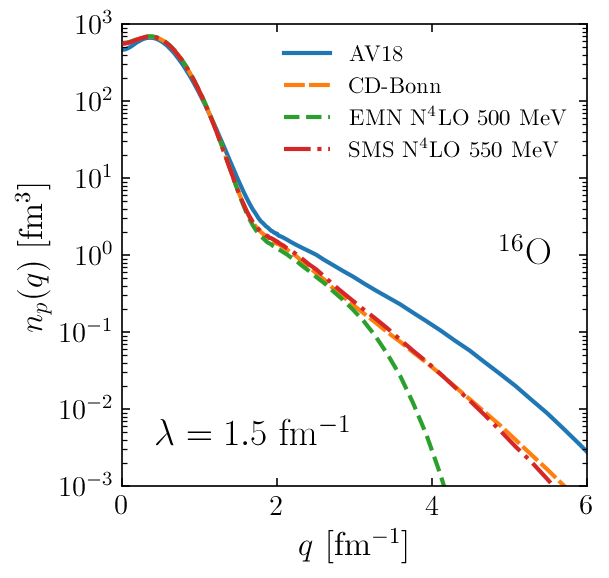

In [16]:
# AV18, CD-Bonn, SMS, and EMN potentials
single_nucleon_momentum_distributions_vary_kvnn(
    'O16', 'proton', (6, 7, 79, 113), 1.5, y_limits=(1e-3,1e3), save=True
)

## Vary $\lambda$

In [17]:
def single_nucleon_momentum_distributions_vary_lambda(
        nucleus_name, nucleon, kvnn, lamb, lamb_min=1.35, lamb_max=2.0,
        x_limits=(0.0,6.0), y_limits=(9e-6,1e3), y_scale='log',
        nucleus_label=False, kvnn_label=False, legend=False, save=False
):
    """Plots momentum distributions varying the SRG flow parameter \lambda."""
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
        
    # Create light red band from minimum \lambda to maximum \lambda
    (q_lmin_array, _, n_lmin_array, _, _, _, _, _, _) = (
        load_momentum_distribution(nucleus_name, nucleon, kvnn, lamb_min)
    )
    n_lmin_array *= (2*np.pi) ** 3  # Same scale as VMC
    
    (q_lmax_array, _, n_lmax_array, _, _, _, _, _, _) = (
        load_momentum_distribution(nucleus_name, nucleon, kvnn, lamb_max)
    )
    n_lmax_array *= (2*np.pi) ** 3  # Same scale as VMC
    
    # Input \lambda and IPM
    (q_array, q_weights, n_array, _, n_ipm_array, _, _, _, _) = (
        load_momentum_distribution(nucleus_name, nucleon, kvnn, lamb)
    )
    n_array *= (2*np.pi) ** 3  # Same scale as VMC
    n_ipm_array *= (2*np.pi) ** 3
    
    # Add curves to plot
    if y_scale == 'linear':
        
        # Light red band
        ax.fill_between(
            q_lmin_array, y1=n_lmax_array * q_lmin_array ** 2,
            y2=n_lmin_array * q_lmin_array ** 2, color='red', alpha=0.15
        )
        # IPM
        ax.plot(q_array, n_ipm_array * q_array ** 2, color='black',
                label=label_lambda(np.inf), ls='dotted', lw=2.0)
        # SRG
        ax.plot(q_array, n_array * q_array ** 2, color='red',
                label=label_lambda(lamb), lw=2.0)
        
    elif y_scale == 'log':
        
        # Light red band
        ax.fill_between(q_lmin_array, y1=n_lmax_array, y2=n_lmin_array,
                        color='red', alpha=0.15)
        # IPM
        ax.plot(q_array, n_ipm_array, color='black', label=label_lambda(np.inf),
                ls='dotted', lw=2.0)
        # SRG
        ax.plot(q_array, n_array, color='red', label=label_lambda(lamb), lw=2.0)

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    if y_scale == 'linear' and nucleon == 'proton':
        ylabel = r"$q^2 n_{p}(q)$ [fm]"
    elif y_scale == 'linear' and nucleon == 'neutron':
        ylabel = r"$q^2 n_{n}(q)$ [fm]"
    elif y_scale == 'log' and nucleon == 'proton':
        ylabel = r"$n_{p}(q)$ [fm" + r'$^3$' + ']'
    elif y_scale == 'log' and nucleon == 'neutron':
        ylabel = r"$n_{n}(q)$ [fm" + r'$^3$' + ']'
    ax.set_ylabel(ylabel, fontsize=16)

    # Set legend
    if legend:
        ax.legend(loc='upper right', fontsize=16, frameon=False)

    # Add nucleus label
    if nucleus_label:
        ax.add_artist(
            AnchoredText(label_nucleus(nucleus_name), loc='lower left',
                         prop=dict(size=18), frameon=False)
        )
        
    # Add potential label
    if kvnn_label:
        ax.add_artist(
            AnchoredText(label_kvnn(kvnn), loc='upper right',
                         prop=dict(size=18), frameon=False)
        )
    
    # Save?
    if save:
        file_name = (f"{nucleus_name}_{nucleon}_momentum_distributions_kvnn"
                     f"_{kvnn}_vary_lambda_{lamb}_{y_scale}_scale")
        file_name = replace_periods(file_name)
        f.savefig(figures_directory + file_name + ".png")

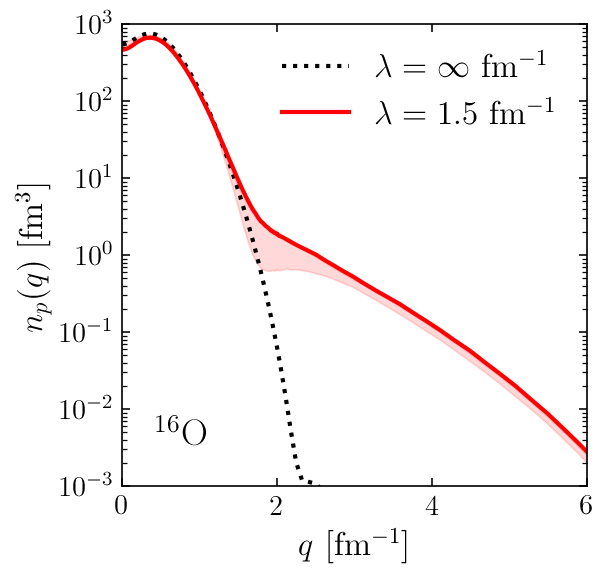

In [18]:
# Log y-scale
single_nucleon_momentum_distributions_vary_lambda(
    'O16', 'proton', 6, 1.5, y_limits=(1e-3, 1e3), nucleus_label=True,
    legend=True, save=True
)

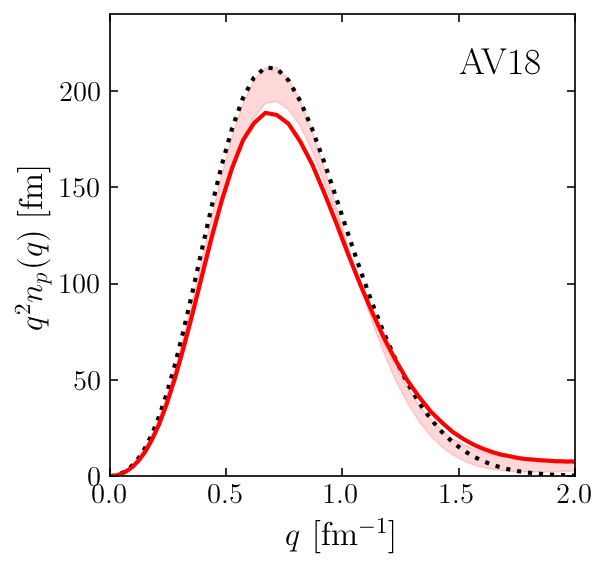

In [19]:
# Linear y-scale
single_nucleon_momentum_distributions_vary_lambda(
    'O16', 'proton', 6, 1.5, x_limits=(0.0, 2.0), y_limits=(-0.1, 240.0),
    y_scale='linear', kvnn_label=True, save=True
)

## Matching interactions

In [20]:
def matching_distribution(
        nucleus_name, nucleon, kvnn, lamb, kvnn_hard, lambm, lambm_min,
        lambm_max, x_limits=(0.0,6.0), y_limits=(9e-6,1e3), y_scale='log',
        nucleus_label=False, lamb_label=False, legend=False, save=False
):
    """Plots momentum distributions matching a soft and hard potential."""
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
        
    # Hard potential
    (q_array, q_weights, n_hard_array, _, _, _, _, _, _) = (
        load_momentum_distribution(nucleus_name, nucleon, kvnn_hard, lamb)
    )
    n_hard_array *= (2*np.pi) ** 3  # Same scale as VMC
        
    # Soft potential
    (q_array, q_weights, n_soft_array, _, _, _, _, _, _) = (
        load_momentum_distribution(nucleus_name, nucleon, kvnn, lamb)
    )
    n_soft_array *= (2*np.pi) ** 3  # Same scale as VMC
    
    # Soft potential with initial 2-body operator
    (q_array, q_weights, n_lambm_array, _, _, _, _, _, _) = (
        load_momentum_distribution(nucleus_name, nucleon, kvnn, lamb, kvnn_hard,
                                   lambm)
    )
    n_lambm_array *= (2*np.pi) ** 3  # Same scale as VMC
        
    # Create light red band from minimum \lambda_m to maximum \lambda_m
    (q_array, _, n_lmin_array, _, _, _, _, _, _) = (
        load_momentum_distribution(nucleus_name, nucleon, kvnn, lamb, kvnn_hard,
                                   lambm_min)
    )
    n_lmin_array *= (2*np.pi) ** 3  # Same scale as VMC
    
    (q_array, _, n_lmax_array, _, _, _, _, _, _) = (
        load_momentum_distribution(nucleus_name, nucleon, kvnn, lamb, kvnn_hard,
                                   lambm_max)
    )
    n_lmax_array *= (2*np.pi) ** 3  # Same scale as VMC
    
    # Label for \lambda_m
    lambm_label = rf"$\lambda_m={lambm}$" + " fm" + r"$^{-1}$"
    
    # Add curves to plot
    if y_scale == 'linear':
        
        # Light red band
        ax.fill_between(
            q_array, y1=n_lmax_array * q_array ** 2,
            y2=n_lmin_array * q_array ** 2, color='red', alpha=0.15, zorder=3
        )
        # Soft potential
        ax.plot(q_array, n_soft_array * q_array ** 2, color='black',
                label=label_kvnn(kvnn), ls='dotted', lw=2.0, zorder=1)
        # Hard potential
        ax.plot(q_array, n_hard_array * q_array ** 2, color='blue',
                label=label_kvnn(kvnn_hard), ls='solid', lw=2.0, zorder=2)
        # Matched distribution
        ax.plot(q_array, n_lambm_array * q_array ** 2, color='red',
                label=lambm_label, ls='dashed', lw=2.0, zorder=4)
        
    elif y_scale == 'log':
        
        # Light red band
        ax.fill_between(q_array, y1=n_lmax_array, y2=n_lmin_array, color='red',
                        alpha=0.15, zorder=3)
        # Soft potential
        ax.plot(q_array, n_soft_array, color='black', label=label_kvnn(kvnn),
                ls='dotted', lw=2.0, zorder=1)
        # Hard potential
        ax.plot(q_array, n_hard_array, color='blue',
                label=label_kvnn(kvnn_hard), ls='solid', lw=2.0, zorder=2)
        # Matched distribution
        ax.plot(q_array, n_lambm_array, color='red', label=lambm_label,
                ls='dashed', lw=2.0, zorder=4)

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    if y_scale == 'linear' and nucleon == 'proton':
        ylabel = r"$q^2 n_{p}(q)$ [fm]"
    elif y_scale == 'linear' and nucleon == 'neutron':
        ylabel = r"$q^2 n_{n}(q)$ [fm]"
    elif y_scale == 'log' and nucleon == 'proton':
        ylabel = r"$n_{p}(q)$ [fm" + r'$^3$' + ']'
    elif y_scale == 'log' and nucleon == 'neutron':
        ylabel = r"$n_{n}(q)$ [fm" + r'$^3$' + ']'
    ax.set_ylabel(ylabel, fontsize=16)

    # Set legend
    if legend:
        ax.legend(loc='upper right', fontsize=13, frameon=False)

    # Add nucleus label
    if nucleus_label:
        ax.add_artist(
            AnchoredText(label_nucleus(nucleus_name), loc='center left',
                         prop=dict(size=18), frameon=False)
        )
        
    # Add \lambda label
    ax.add_artist(
        AnchoredText(label_lambda(lamb), loc='lower left', prop=dict(size=18),
                     frameon=False)
    )
    
    # Save?
    if save:
        file_name = (
            f"{nucleus_name}_{nucleon}_matching_distribution_kvnn_{kvnn}_lamb"
            f"_{lamb}_kvnn_hard_{kvnn_hard}_lambm_{lambm}_{y_scale}_scale"
        )
        file_name = replace_periods(file_name)
        f.savefig(figures_directory + file_name + ".png")

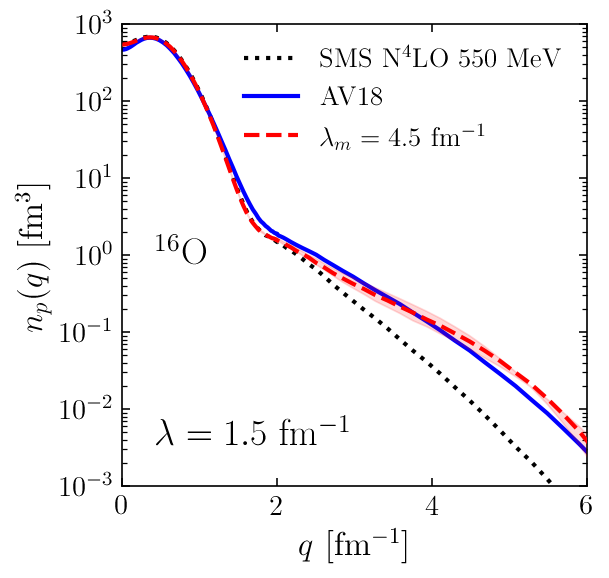

In [21]:
# Matching SMS N4LO 550 MeV to AV18
matching_distribution(
    'O16', 'proton', 113, 1.5, 6, 4.5, 4.0, 5.0, y_limits=(1e-3, 1e3),
    nucleus_label=True, lamb_label=True, legend=True, save=True
)

## Extra figures

In [22]:
def single_nucleon_momentum_distributions_multipanel_extra(
        nuclei, nucleon, kvnn, lamb, x_limits=(0.0,6.0), y_limits=(1e-4,1e3),
        y_scale='log', show_vmc=False, save=False
):
    """Plot a single-nucleon momentum distribution with several built-in
    options.
    """
    
    # Initialize figure
    plt.close('all')
    row_number, col_number = 1, len(nuclei)
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True,
                          figsize=(4*col_number, 4*row_number))
        
    # Loop over nuclei
    for i, nucleus in enumerate(nuclei):
        
        nucleus_name, Z, N = nucleus
        if nucleon == 'proton':
            factor = Z
        elif nucleon == 'neutron':
            factor = N
            
        if y_scale == 'log':
            axs[i].set_yscale('log')
        else:
            axs[i].set_yscale('linear')
        
        # Compare to VMC calculation?
        if show_vmc:

            # AV18 only
            file_name = f"{nucleus_name}_single_nucleon_av18.txt"
            
            data = np.loadtxt(vmc_directory + file_name)
            q_vmc = data[:,0]
            n_vmc = data[:,1] / factor
            n_errors = data[:,2] / factor
        
            if y_scale == 'linear':
            
                axs[i].errorbar(
                    q_vmc, n_vmc * q_vmc ** 2, yerr=n_errors * q_vmc ** 2,
                    color='black', label='VMC', linestyle='', marker='.',
                    zorder=3
                )
            
            else:
            
                axs[i].errorbar(
                    q_vmc, n_vmc, yerr=n_errors, color='black', label='VMC',
                    linestyle='', marker='.', zorder=3
                )

        # Load data from file
        if nucleus_name == 'He4' or nucleus_name == 'C12':
            q_array, q_weights, n_array, n_errors, n_ipm_array, _, _, _, _ = (
                load_momentum_distribution(nucleus_name, nucleon, kvnn, lamb,
                                           parametrization='')
            )
        elif nucleus_name == 'O16' or nucleus_name == 'Ca40':
            q_array, q_weights, n_array, n_errors, n_ipm_array, _, _, _, _ = (
                load_momentum_distribution(nucleus_name, nucleon, kvnn, lamb,
                                           parametrization='Match')
            )
    
        # Multiply by factor (2\pi)^3 / Z (N) to compare to VMC data
        n_array *= (2*np.pi) ** 3 / factor
        n_errors *= (2*np.pi) ** 3 / factor
        n_ipm_array *= (2*np.pi) ** 3 / factor

        # Add to plot
        if y_scale == 'linear':
        
            # SRG
            axs[i].plot(q_array, n_array * q_array ** 2, label='SRG',
                        linewidth=2.0, zorder=2)
            # IPM
            axs[i].plot(q_array, n_ipm_array * q_array ** 2, label='IPM',
                        linestyle='dotted', linewidth=2.0, zorder=1)

        else:
        
            # SRG
            axs[i].plot(q_array, n_array, label='SRG', linewidth=2.0, zorder=2)
            # IPM
            axs[i].plot(q_array, n_ipm_array, label='IPM', linestyle='dotted',
                        linewidth=2.0, zorder=1)

        # Set axes limits
        axs[i].set_xlim(x_limits)
        axs[i].set_ylim(y_limits)

        # Set axes labels
        axs[i].set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
        if i == 0:  # First column only
            if y_scale == 'linear' and nucleon == 'proton':
                ylabel = r"$q^2 n_{p}(q)/Z$ [fm]"
            elif y_scale == 'linear' and nucleon == 'neutron':
                ylabel = r"$q^2 n_{n}(q)/N$ [fm]"
            elif y_scale == 'log' and nucleon == 'proton':
                ylabel = r"$n_{p}(q)/Z$ [fm" + r'$^3$' + ']'
            elif y_scale == 'log' and nucleon == 'neutron':
                ylabel = r"$n_{n}(q)/N$ [fm" + r'$^3$' + ']'
            axs[i].set_ylabel(ylabel, fontsize=16)

        # Add nucleus label
        if y_scale == 'log':
            nucleus_label_loc = 'lower left'
        elif y_scale == 'linear':
            nucleus_label_loc = 'upper left'
        axs[i].add_artist(
            AnchoredText(label_nucleus(nucleus_name), loc=nucleus_label_loc,
                         prop=dict(size=18), frameon=False)
        )
        
    # Set legend in first panel only
    axs[0].legend(loc='upper right', fontsize=13, frameon=False)
    
    # Add potential and \lambda label in last panel
    axs[-1].add_artist(
        AnchoredText(label_potential_lambda(kvnn, lamb), loc='upper right',
                     prop=dict(size=18), frameon=False)
    )

    # Amount of white space in-between sub-plots
    f.subplots_adjust(wspace=0.1)

    # Save?
    if save:   
        file_name = replace_periods(
            f"{nucleon}_momentum_distributions_kvnn_{kvnn}_lamb_{lamb}"
            f"_{y_scale}_scale_av18_only"
        )
        f.savefig(figures_directory + file_name + '.png')

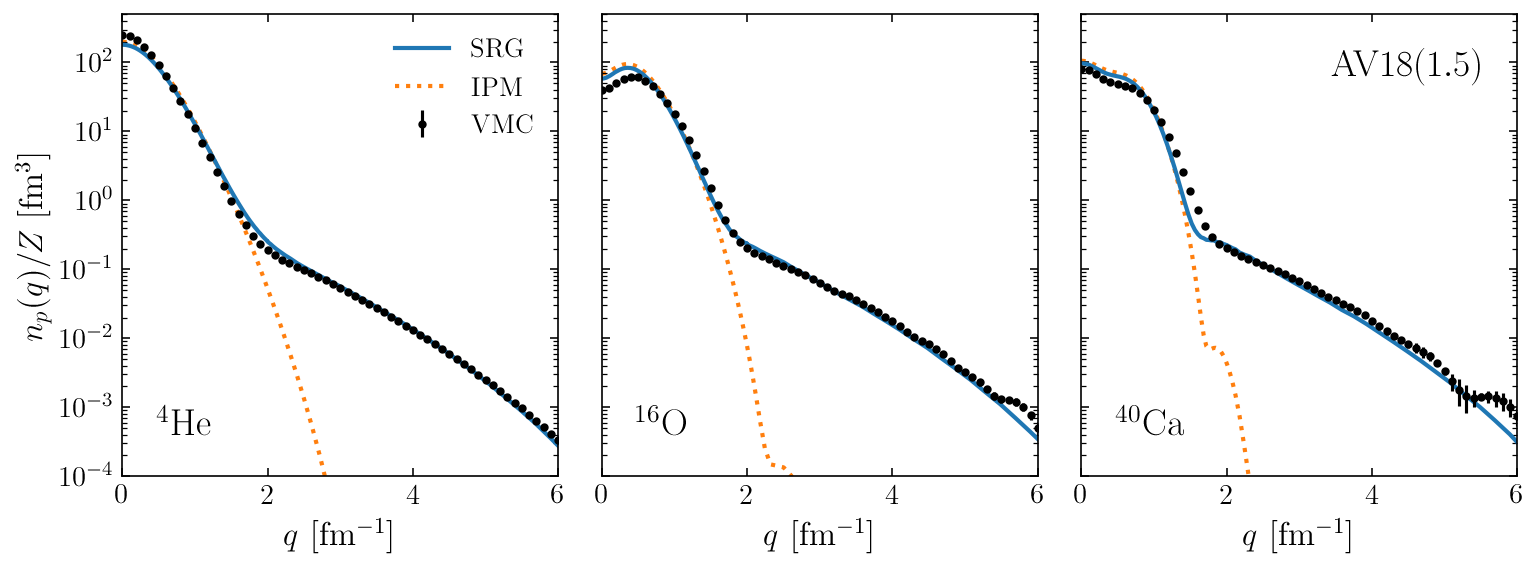

In [23]:
# \lambda = 1.5 fm^-1 log y scale

nuclei = (('He4', 2, 2), ('O16', 8, 8), ('Ca40', 20, 20))

single_nucleon_momentum_distributions_multipanel_extra(
    nuclei, 'proton', 6, 1.5, y_limits=(1e-4, 5e2), show_vmc=True, save=True
)

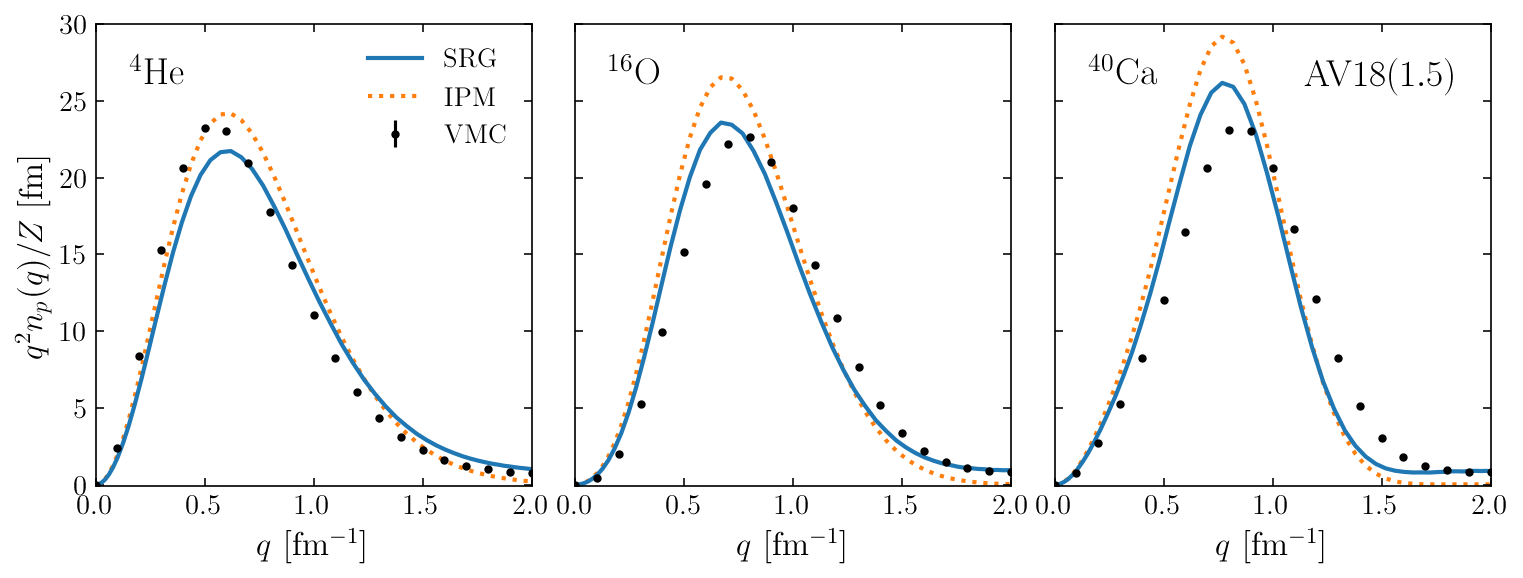

In [24]:
# \lambda = 1.5 fm^-1 linear y scale

nuclei = (('He4', 2, 2), ('O16', 8, 8), ('Ca40', 20, 20))

single_nucleon_momentum_distributions_multipanel_extra(
    nuclei, 'proton', 6, 1.5, x_limits=(0.0, 2.0), y_limits=(-0.1, 30),
    y_scale='linear', show_vmc=True, save=True
)